v2_dreamink, a sailing ship on a rainbow ocean


  0%|          | 0/15 [00:00<?, ?it/s]

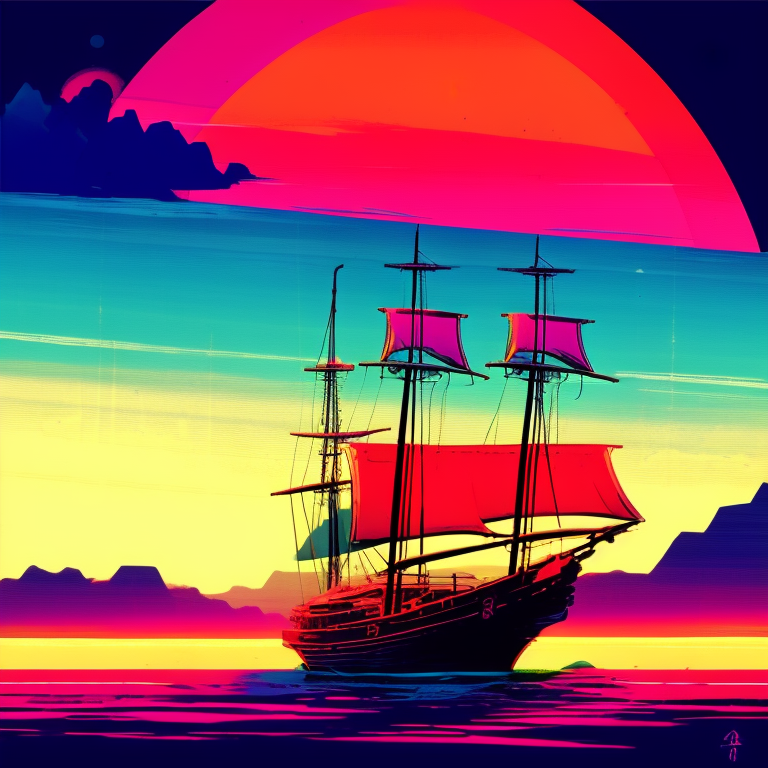

In [3]:
#install
try:
  import torch
  from src import SimpleStable
except ImportError as e:
  print("Installing required libraries...")
  !pip3 install torch torchvision torchaudio diffusers transformers accelerate scipy pillow tqdm requests huggingface_hub ipywidgets --extra-index-url https://download.pytorch.org/whl/cu116 > /dev/null
  %cd /content/
  !git clone https://github.com/cadaeix/simplest-stable.git > /dev/null
  outputs_path = "/content/images/"
  !mkdir -p $outputs_path
  print(f"Outputs will be saved to {outputs_path}.")

%cd /content/simplest-stable/
import sys
sys.path.append(".")
from IPython.display import display, clear_output
from datetime import datetime
import os
import random
import math
import random
import torch
from tqdm import tqdm
import json
import PIL
import numpy as np
from PIL import Image
from diffusers import AutoencoderKL, EulerAncestralDiscreteScheduler, EulerDiscreteScheduler, LMSDiscreteScheduler, DPMSolverSinglestepScheduler, DPMSolverMultistepScheduler
from src import SimpleStable, utils, SimpleStableDiffusionPipeline
clear_output(wait=False)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

#@markdown ### <b>Model Choice </b>
model = "Stable Diffusion 2.0 (768)" #@param ["Stable Diffusion 1.4","Stable Diffusion 1.5","Stable Diffusion 2.0 (512)","Stable Diffusion 2.0 (768)","Stable Diffusion 2.1 (512)","Stable Diffusion 2.1 (768)","Pokemon Diffusion","Waifu Diffusion 1.3", "Waifu Diffusion 1.4 (Epoch 1 Test Version)", "Anything v3.0","seek.art_MEGA","Robo Diffusion","Inkpunk Diffusion","Classic Animation Diffusion","Modern Animation Diffusion","Ghibli Diffusion","Van Gogh Diffusion","Openjourney","Dreamlike Diffusion","Future Diffusion","Gigafractal Diffusion","Stable Diffusion 1.4 with VAE","Stable Diffusion 1.5 with VAE"] {type:"string"}
add_automatic_keyword = True #@param {type: "boolean"}
#@markdown ### <b>Image Generation</b><br>
#@markdown See previous cell for setting explanations
prompt = "v2_dreamink, a sailing ship on a <color> ocean" #@param{type:"string"}
negative = "" #@param{type: 'string'}
resolution = "Custom (Select this and put width and height below)" #@param ["Custom (Select this and put width and height below)", "Square 512x512 (default, good for most models)", "Landscape 768x512", "Portrait 512x768", "Square 768x768 (good for 768 models)", "Landscape 1152x768 (does not work on free colab)", "Portrait 768x1152 (does not work on free colab)"] {type:"string"}

#width_height = [768,512] #@param{type: 'raw'}
#@markdown <br>
#@markdown <b>Advanced Settings</b>
width_height_if_custom_is_selected = [768, 768] #@param{type: 'raw'}
steps = 15 #@param {type:"integer"}
samples_per_batch = 1
number_of_images = 1 #@param {type:"integer"}
seed = 42 #@param {type:"integer"}
sampler = "Euler a" #@param ["Euler a", "Euler", "KLMS", "DPMSolver++ (2S) (has issues with img2img)", "DPMSolver++ (2M)"] {type:"string"}
batch_name = ""
batch_name = batch_name + datetime.now().strftime("%H:%M:%S")
guidance_scale = 7 #@param {type:"slider", min:0, max:20, step:0.5}
ddim_eta = 0.0
zoom = False
tiling = False #@param {type: "boolean"}
#@markdown If `tiling` results look poor, double the amount of steps from non-tiling.
#@markdown <br>
#@markdown <br>
#@markdown
#@markdown ---

#@markdown <b>Init image</b><br>
init_image_or_folder = "" #@param {type:"string"}
denoising_strength = 0.9 #@param {type:"slider", min:0.1, max:1.0, step:0.05}
#@markdown <br>
#@markdown
#@markdown ---

#@markdown <b>Upscaling</b><br>

upscale_results = False #@param {type: 'boolean'}
# detailing = 1 #@param {type:"slider", min:1, max:4, step:1}
upscale_strength = 0.2 #@param {type:"slider", min:0.0, max:1.0, step:0.05}
######

res_dict = {"Square 512x512 (default, good for most models)": [512,512],
            "Landscape 768x512": [768,512],
            "Portrait 512x768": [512,768],
            "Square 768x768 (good for 768 models)": [768,768],
            "Landscape 1152x768 (does not work on free colab)": [1152,768],
            "Portrait 768x1152 (does not work on free colab)":[768,1152]}
width, height = width_height_if_custom_is_selected if resolution == "Custom (Select this and put width and height below)" else res_dict[resolution]

opt = {
    "model_name" : model,
    "vae_name" : "",
    "eta" : 0.0,
    "steps" : steps,
    "fixed_code" : True,
    "init_img" : init_image_or_folder if init_image_or_folder != "" else None,
    "n_iter" : 1,
    "batches" : number_of_images, #how many
    "outdir" : "",
    "precision" : 'autocast',
    "prompt" : prompt,
    "negative" : negative,
    "sampler" : sampler,
    "tiling" : tiling,
    "scale" : guidance_scale,
    "seed" : seed,
    "strength" : denoising_strength if init_image_or_folder != "" else None, # strength for noising/unnoising. 1.0 corresponds to full destruction of information in init image
    "H" : height - height % 64,
    "W" : width - width % 64,
    #upscale stuff
    "passes" : 1,
    "upscale": upscale_results,
    "gobig_overlap" : 128,
    #"detail_steps" : steps*detailing,
    "upscale_strength" : upscale_strength,
    "detail_scale" : 10,
    "add_keyword": add_automatic_keyword
    }

recreate = False
try:
  pipe
  recreate = model_name != opt["model_name"]
except NameError as e:
  pipe = None
  recreate = True
model_name = opt["model_name"]

embeddings_list = []

pipe = SimpleStable.main(opt, pipe, recreate, embeddings_list)

